In [1]:
import torch
from torch import nn

In [3]:
from d2l_common import Module


class GRUScratch(Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape)*sigma)

        def triple(): return (init_weight((num_inputs, num_hiddens)), init_weight(
            num_hiddens, num_hiddens), nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple() # update gate
        self.W_xr, self.W_hr, self.b_r = triple() # reset gate
        self.W_xh, self.W_hh, self.b_h = triple() # candidate hidden gate
    
    def forward(self, inputs, H=None):
        if H is None:
            H = torch.zeros((inputs.shape[1],self.num_hiddens), device=inputs.device)
        outputs = []
        for X in inputs:
            Z = torch.sigmoid(X@self.W_xz + H@self.W_hz+self.b_z)
            R = torch.sigmoid(X@self.W_xr + H@self.W_hr+self.b_r)
            H_tilde = torch.sigmoid(X@self.W_xh + H@self.W_hh+self.b_h)
            H = Z*H + (1-Z)*H_tilde
            outputs.append(H)
        return outputs, H

In [10]:
from d2l_common import TimeMachine, Trainer, RNNLMScratch

data = TimeMachine(batch_size=1024, num_steps=32, device='mps')
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(gru, len(data.vocab), lr=4).to('mps')
trainer = Trainer(max_epochs=1000, gradient_clip_val=1)
trainer.fit(model, data)


complete 0 epoch train_loss=3.96101713180542 validate_loss=3.951815366744995
complete 1 epoch train_loss=3.951815366744995 validate_loss=3.943110942840576
complete 2 epoch train_loss=3.943110942840576 validate_loss=3.9346115589141846
complete 3 epoch train_loss=3.9346115589141846 validate_loss=3.926154375076294
complete 4 epoch train_loss=3.926154375076294 validate_loss=3.9177017211914062
complete 5 epoch train_loss=3.9177017211914062 validate_loss=3.909336566925049
complete 6 epoch train_loss=3.909336566925049 validate_loss=3.9012393951416016
complete 7 epoch train_loss=3.9012393951416016 validate_loss=3.893616199493408
complete 8 epoch train_loss=3.893616199493408 validate_loss=3.8865885734558105
complete 9 epoch train_loss=3.8865885734558105 validate_loss=3.880124807357788
complete 10 epoch train_loss=3.880124807357788 validate_loss=3.874102830886841
complete 11 epoch train_loss=3.874102830886841 validate_loss=3.8684306144714355
complete 12 epoch train_loss=3.8684306144714355 valida

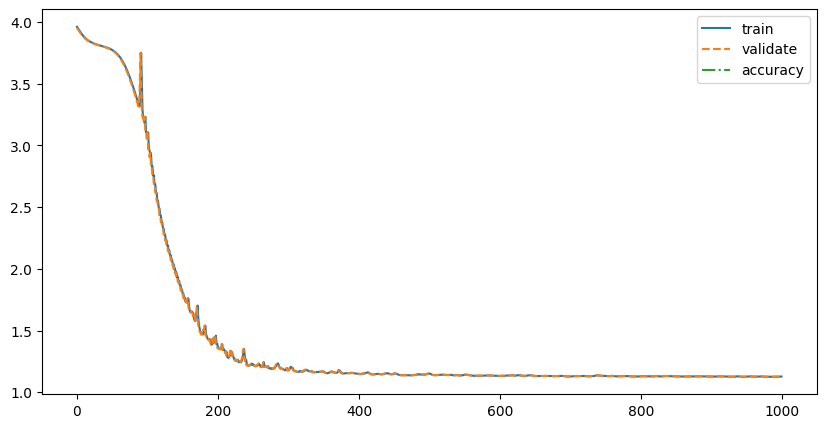

In [11]:
trainer.plot()

In [13]:
model.predict('it has', 50, data.vocab, device='mps')

'it hasrrrrrgbrgbrgbrgbrbrofrofbrbbrrbrofbrbbrrbrofbrbbrr'